
Starting Method: SGD
input_dim: 3
[[ -7.09234794e+12]]
Iteration: 50
[[-51502879.46541081]]
Iteration: 100
[[-51873031.31500077]]
Iteration: 150
[[-53027771.81104063]]
Iteration: 200
[[-51498269.44821128]]
Iteration: 250
[[-51866896.53791919]]
Iteration: 300
[[-52996353.88303755]]
Iteration: 350
[[-51493860.6227869]]
Iteration: 400
[[-51861007.70069338]]
Iteration: 450
[[-52966372.84368647]]
Iteration: 500
[[-51489638.95255856]]

NLPD per output using SGD method: [array([ 1.99205179, -0.1820585 ,  0.69343134,  1.70378785,  1.50073111])]

Starting Method: Adam
input_dim: 3
[[ -7.09234794e+12]]
Iteration: 50
[[ -1.69190415e+11]]
Iteration: 100
[[ -9.85625342e+09]]
Iteration: 150
[[-78672850.25405201]]
Iteration: 200
[[ -1.17791353e+08]]
Iteration: 250
[[ -5.30258829e+09]]
Iteration: 300
[[-58782641.54716638]]
Iteration: 350
[[-93837827.84824701]]
Iteration: 400
[[ -3.57179367e+09]]
Iteration: 450
[[-50356882.43868107]]
Iteration: 500
[[-80542655.29411545]]

NLPD per output using ADAM me

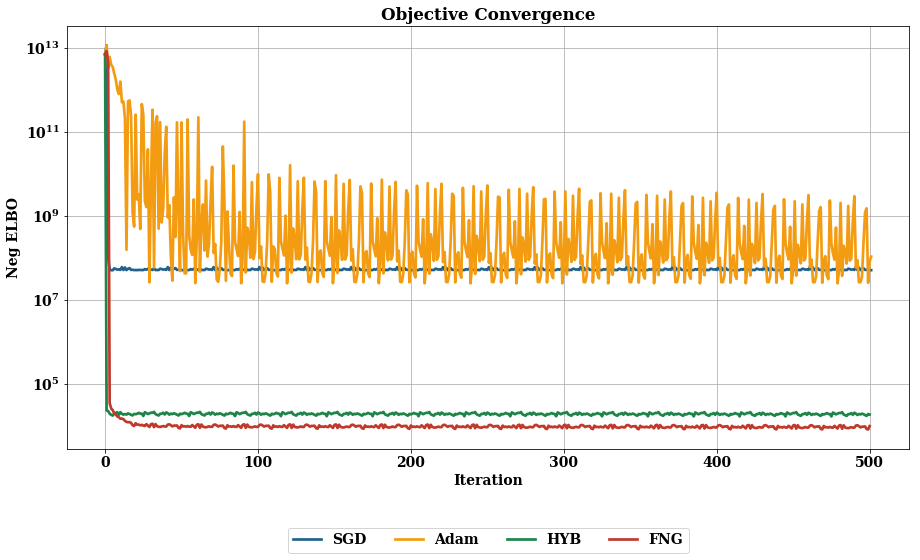

In [37]:
import sys
import climin
import warnings
import os
sys.path.append('..')
sys.path.append('/home/juanj/My_codes_py/Codes_HeteroGP/HetMOGP-master')
sys.path.append('/home/juanj/My_codes_py/Fully_Natural_Gradient') 

import fully_natural_gradient as fng
import load_datasets as pre
from importlib import reload
reload(fullyNG)
reload(pre)

import numpy as np
from likelihoods.poisson import Poisson
from likelihoods.bernoulli import Bernoulli
from likelihoods.gaussian import Gaussian
from likelihoods.categorical import Categorical
from likelihoods.hetgaussian import HetGaussian
from likelihoods.beta import Beta
from likelihoods.gamma import Gamma
from likelihoods.exponential import Exponential

from hetmogp.util import draw_mini_slices
from hetmogp.het_likelihood import HetLikelihood
from hetmogp.svmogp import SVMOGP
from hetmogp import util
reload(util)

import matplotlib.pyplot as plt
import time
import getopt

warnings.filterwarnings("ignore")
os.environ['PATH'] = os.environ['PATH'] + ':/usr/texbin'
""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""
class inital_config:
    def __init__(self):
        
        self.minibatch = 50
        self.inducing = 80
        self.dimension = 3
        self.N_iter = 500
        self.dataset = 'toy4'
        self.MC = 1
        self.mom = 0.9
        self.which_model = 'HetMOGP'
        self.which_seed = 105

""""""""""""""""""""""""""""""
config = inital_config()
num_inducing = int(config.inducing)  # number of inducing points
batch = int(config.minibatch)
input_dim = int(config.dimension)
MC = int(config.MC)
mom = float(config.mom)
""""""""""""""""""""""""""""""
which_color = {
		"Adam" : '#f39c12',
		"SGD" : '#21618c',
		"FNG" : '#c0392b',
		"HYB" : '#1e8449'
	}

""""""""""""""""""""""""""""""
methods = ['SGD','Adam','HYB','FNG']
#methods = ['HYB','FNG']
myseed = int(config.which_seed)
NLPD_Adam = []
NLPD_FNG = []
NLPD_SGD = []
NLPD_HYB = []
ELBO_Adam = []
ELBO_FNG = []
ELBO_SGD = []
ELBO_HYB = []

#import random

plt.close('all')
plt.figure(figsize=(13, 8))
for posmeth,method in enumerate(methods):
    print("\nStarting Method:", method)
    np.random.seed(101)
    import random
    random.seed(101)
    model=[]

    """"""""""""""""""""""""""""""""""""""
    def callback(i):
        global n_iter, start, Xval, Yval
        global ELBO, myTimes, NLPD

        ELBO.append(model.log_likelihood())
        # if i['n_iter'] == 1:
        #     start = time.time()
        myTimes.append(time.time())

        if (i['n_iter']) % 50 == 0:
            print("Iteration:",i['n_iter'])
            print(model.log_likelihood())
        if i['n_iter'] > n_iter:
            myTimes = np.array(myTimes) - start
            return True
        return False
    """"""""""""""""""""""""""""""""""""""
    dataset=config.dataset
    Xtrain,Ytrain = pre.load_Hetdata(dataset=dataset,Ntoy=2000,Only_input_dim_toy=input_dim)
    """"""""""""""""""""""""""""""""""""""

    # Likelihood Definition
    if dataset == 'london':
        my_proportion = [0.75, 0.75]
        incomplete_out = np.inf
        likelihoods_list = [HetGaussian(), Bernoulli()]
        Q = 3  # number of latent functions
    elif dataset == 'naval_beta_gamma':
        Q = 4  # number of latent functions
        my_proportion = [0.75, 0.75]
        incomplete_out = np.inf
        likelihoods_list = [Beta(), Gamma()]
    elif dataset == 'toy1':
        Q = 3
        incomplete_out = np.inf  # this means which position of output if zero means HetGauss, if one then is Bernoulli
        my_proportion = [0.75, 0.75]  # this is the proportio to use per output
        likelihoods_list = [HetGaussian(), Beta()]
    elif dataset == 'toy2':
        Q = 3
        incomplete_out = np.inf  # this means which position of output if zero means HetGauss, if one then is Bernoulli
        my_proportion = [0.75, 0.75, 0.75]  # this is the proportio to use per output
        likelihoods_list = [HetGaussian(), Beta(), Bernoulli()]
    elif dataset == 'toy3':
        Q = 3
        incomplete_out = np.inf  # this means which position of output if zero means HetGauss, if one then is Bernoulli
        my_proportion = [0.75, 0.75, 0.75]  # this is the proportio to use per output
        likelihoods_list = [HetGaussian(), Beta(), Gamma()]
    elif dataset == 'toy4':
        Q = 3
        incomplete_out = np.inf  # this means which position of output if zero means HetGauss, if one then is Bernoulli
        my_proportion = [0.75, 0.75, 0.75, 0.75, 0.75]  # this is the proportio to use per output
        likelihoods_list = [HetGaussian(), Beta(), Bernoulli(), Gamma(), Exponential()]
    elif dataset == 'toy5':
        Q = 3
        incomplete_out = np.inf  # this means which position of output if zero means HetGauss, if one then is Bernoulli
        my_proportion = [0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75]  # this is the proportio to use per output
        likelihoods_list = [HetGaussian(), Beta(), Bernoulli(), Gamma(), Exponential(), Gaussian(sigma=0.1), Beta(), Bernoulli(), Gamma(), Exponential()]
    elif dataset == 'toy6':
        Q = 3
        incomplete_out = 0  # this means which position of output if zero means HetGauss, if one then is Bernoulli
        my_proportion = [0.75, 0.75, 0.75]  # this is the proportio to use per output
        likelihoods_list = [HetGaussian(), Bernoulli(), Beta()]
    elif dataset == 'toy7':
        Q = 3
        my_proportion = [0.75, 0.75, 0.75]
        likelihoods_list = [HetGaussian(), HetGaussian(), HetGaussian()]
    elif dataset == 'toy8':
        Q = 3
        my_proportion = [0.75, 0.75, 0.75]
        likelihoods_list = [Bernoulli(), Bernoulli(), Bernoulli()]
    elif dataset == 'toy9':
        Q = 3
        my_proportion = [0.75, 0.75, 0.75]
        likelihoods_list = [Beta(), Gamma(), Beta()]
    elif dataset == 'toy10':
        Q = 3
        my_proportion = [0.75, 0.75, 0.75]
        likelihoods_list = [Poisson(), Poisson(), Poisson()]
    elif dataset == 'toy11':
        Q = 3
        my_proportion = [0.75, 0.75, 0.75]
        likelihoods_list = [Gaussian(sigma=0.2), Gaussian(sigma=0.2), Gaussian(sigma=0.2)]
    elif dataset == 'toy12':
        Q = 3
        my_proportion = [0.75, 0.75, 0.75]
        likelihoods_list = [HetGaussian(), Gamma(), Beta()]
    elif dataset == 'toy13':
        Q = 2
        my_proportion = [0.75, 0.75]
        likelihoods_list = [Bernoulli(), Poisson()]
    elif dataset == 'toy14':
        Q = 3
        my_proportion = [0.75, 0.75]
        likelihoods_list = [Poisson(), Gaussian(sigma=0.2)]
    elif dataset == 'toy15':
        Q = 3
        incomplete_out = np.inf  # this means which position of output if zero means HetGauss, if one then is Bernoulli
        my_proportion = [0.75, 0.75, 0.75, 0.75, 0.75]  # this is the proportio to use per output
        likelihoods_list = [HetGaussian(), Beta(), Bernoulli(), Gamma(), Poisson()]

    likelihood = HetLikelihood(likelihoods_list)
    Y_metadata = likelihood.generate_metadata()

    np.random.seed(101)
    myindex = []
    ind_split_aux = []

    if Ytrain.__len__() == 1:
        Kfold = 4
    else:
        Kfold = 2

    proportion = 1.0 / Kfold
    if dataset=='london':    # human and naval_beta_gamma use the same as the toys
        alim1 = 0.15; alim2=0.5
    elif dataset=='naval_beta_gamma':
        alim1 = 0.11; alim2 = 0.41
    else:
        alim1 = 0.2; alim2 = 0.8

    for d in range(Ytrain.__len__()):
        Ntotal, Dim = Xtrain[d].shape

        if Kfold==2:
            proportion = 1.0-my_proportion[d]

        if d==incomplete_out:
            myindex.append(np.arange(0, Ntotal))
            alim = Xtrain[d] < (alim1 ** (1 / Dim))
            blim = Xtrain[d] > (0.02)
            aalim = Xtrain[d] < (alim2 ** (1 / Dim))
            bblim = Xtrain[d] > (0.4)
            clim = alim * blim
            cclim = aalim * bblim
            dtotal1 = clim[:, 0]
            dtotal2 = cclim[:, 0]
            for dimi in range(Xtrain[d].shape[1] - 1):
                dtotal1 = dtotal1 * clim[:, dimi + 1]
                dtotal2 = dtotal2 * cclim[:, dimi + 1]
            # ind_split_aux.append(myindex[d][True ^ dtotal])
            dtotal = dtotal1 + dtotal2
            ind_split_aux.append([myindex[d][dtotal], myindex[d][dtotal], myindex[d][dtotal], myindex[d][dtotal]])
        else:
            myindex.append(np.random.permutation(np.arange(0, Ntotal)))
            ind_split_aux.append(np.split(myindex[d], np.arange(int(Ntotal * proportion), Ntotal, int(Ntotal * proportion))))
            if not (Ntotal % Kfold == 0):
                ind_split_aux[d] = ind_split_aux[d][0:Kfold]

    ind_split = [0.0] * Kfold
    for k in range(Kfold):
        ind_split[k] = []
        for d in range(Ytrain.__len__()):
            ind_split[k].append(ind_split_aux[d][k])

    # kmeans for selecting Z
    from scipy.cluster.vq import kmeans
    np.random.seed(myseed)
    #Z = 1.0 * kmeans(Xtrain, num_inducing)[0]

    minis = Xtrain[0].min(0)
    maxis = Xtrain[0].max(0)
    Dim = Xtrain[0].shape[1]
    Z = np.linspace(minis[0],maxis[0],num_inducing).reshape(1,-1)
    for i in range(Dim-1):
        Zaux = np.linspace(minis[i+1],maxis[i+1],num_inducing)
        Z = np.concatenate((Z,Zaux[np.random.permutation(num_inducing)].reshape(1,-1)),axis=0)
        #Z = np.concatenate((Z, Zaux.reshape(1, -1)), axis=0)
    Z = 1.0*Z.T

    n_iter = int(config.N_iter)
    all_NLPD = []
    Times_all = []
    ELBO_all =[]
    for fold, index in enumerate(ind_split):
        #random.seed(101)
        #np.random.seed(101)
        ELBO = []
        NLPD = []
        myTimes = []
        if fold==1:
            #    break
            #ind = np.delete(myindex, index)
            Y = [Yaux[np.delete(myindex[d], index[d])].copy() for d,Yaux in enumerate(Ytrain)]
            X = [Xaux[np.delete(myindex[d], index[d]), :].copy() for d,Xaux in enumerate(Xtrain)]
            Yval = [Yaux[index[d]].copy() for d,Yaux in enumerate(Ytrain)]
            Xval = [Xaux[index[d], :].copy() for d,Xaux in enumerate(Xtrain)]

            #np.random.seed(int(config.seed))
            np.random.seed(myseed)

            if Q == 1:
                ls_q = np.sqrt(Dim) * (np.random.rand(Q) + 0.001)
            elif (dataset == 'naval_beta_gamma'):
                ls_q = np.sqrt(Dim) * (np.random.rand(Q) + 0.001)
            elif (dataset == 'london' or dataset == 'human'):
                ls_q = 0.1 * np.sqrt(Dim) * (np.random.rand(Q) + 0.001)
            else:
                ls_q = np.sqrt(Dim) * (np.random.rand(Q) + 0.001)
                # ls_q = np.random.rand(Q) + 0.01

            #print("Initial lengthscales:", ls_q)
            if Q == 1:
                var_q = 1.0 * np.ones(Q)  # use 0.1 for toy 0.1 0.5
            elif (dataset == 'naval_beta_gamma' or dataset == 'human' or dataset == 'london'):
                var_q = 1.0 * np.ones(Q)
            else:
                var_q = 1.0 * np.ones(Q)

            kern_list = util.latent_functions_prior(Q, lenghtscale=ls_q, variance=var_q, input_dim=Dim)

            # MODEL
            random.seed(101)
            model = SVMOGP(X=X, Y=Y, Z=Z.copy(), kern_list=kern_list, likelihood=likelihood, Y_metadata=Y_metadata,batch_size=batch)
            #model.Z.fix()
            model['.*.kappa'].fix()
            if ('toy' in dataset):
                for q in range(Q):
                    model['B_q' + str(q) + '.W'] = 2.0 * np.random.rand(model['B_q0.W'].__len__())[:, None]
                    model.kern_list[q].rbf.variance.fix()
                    model.kern_list[q].white.variance = 1.0e-8
                    model.kern_list[q].white.fix()
            elif (config.which_model == 'HetMOGP'):
                for q in range(Q):
                    model['B_q' + str(q) + '.W'] = 2.0 * np.random.rand(model['B_q0.W'].__len__())[:, None]
                    model.kern_list[q].rbf.variance = 1.0
                    model.kern_list[q].rbf.variance.fix()
                    model.kern_list[q].white.variance = 1.0e-8
                    model.kern_list[q].white.fix()

            print(model.log_likelihood())

            if method == 'Adam':
                opt = climin.Adam(model.optimizer_array, model.stochastic_grad, step_rate=0.01, decay_mom1=1 - 0.9,decay_mom2=1 - 0.999)
                ELBO.append(model.log_likelihood())
                start = time.time()
                myTimes.append(start)
                info = opt.minimize_until(callback)

            elif method == 'SGD':
                opt = climin.GradientDescent(model.optimizer_array, model.stochastic_grad, step_rate=1e-15, momentum=0.5)
                ELBO.append(model.log_likelihood())
                start = time.time()
                myTimes.append(start)
                info = opt.minimize_until(callback)
            elif method == 'FNG':
                model.Gauss_Newton = False
                if dataset=='naval_beta_gamma': tao_VI=3;
                else: tao_VI=2
                ELBO, NLPD, myTimes = fng.fullyng_opt_HetMOGP(model, max_iters=n_iter, step_size=0.01, momentum=mom,MC=MC,tao_VI=tao_VI)
            elif method=='HYB':
                model.Gauss_Newton = False
                ELBO, NLPD, myTimes = fng.hybrid_opt_HetMOGP(model, max_iters=n_iter, step_rate=0.01, decay_mom1=1-0.9,decay_mom2=1-0.999)

            Times_all.append(np.array(myTimes).flatten())
            ELBO_all.append(np.array(ELBO).flatten())

            np.random.seed(101)
            eval('NLPD_' + method + '.append(model.negative_log_predictive(Xval,Yval))')
            print("\nNLPD per output using "+method.upper()+" method:", eval('NLPD_' + method ))

    color = which_color[method]

    font = {'family': 'serif',
            'weight': 'bold',
            'size': 14}

    plt.rc('font', **font)
    linewidth = 2.7

    i=0
    
    plt.semilogy(-ELBO_all[0], color, linewidth=linewidth, label=method)
    plt.title("Objective Convergence",fontweight="bold")
    plt.xlabel("Iteration", fontweight="bold")
    plt.ylabel("Neg ELBO", fontweight="bold")
    if (ELBO_all[0].max() > 0):
        plt.yscale('symlog')
    else:
        plt.yscale('log')
    plt.grid(True, which='both')
    plt.gca().legend(methods, loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.17))
    plt.tight_layout()
    plt.savefig(dataset+'.png')